In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from itertools import combinations
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

# Download necessary NLTK packages
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [44]:
df = pd.read_csv("../PreProcessingResumes/processed_data/Resume.csv")
df.head()

,ID,Resume_str,Category
0,16852973,hr administrator marketing associate hr admini...,HR
1,22323967,hr specialist us hr operations summary versati...,HR
2,33176873,hr director summary over years experience in r...,HR
3,27018550,hr specialist summary dedicated driven and dyn...,HR
4,17812897,hr manager skill highlights hr skills hr depar...,HR


In [45]:
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Category'])

In [46]:
# Create tagged documents for the training set (each resume is tokenized and assigned a unique tag, 
# which is necessary for training a Doc2Vec model to distinguish between different documents)
tagged_train = [
    TaggedDocument(words=word_tokenize(doc), tags=[str(i)]) 
    for i, doc in enumerate(train['Resume_str'])
]

tagged_test = [
    TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)])
    for i, _d in enumerate(test['Resume_str'])
]

In [47]:
print(f"First document:\n Words: {tagged_train[0].words}\n Tag: {tagged_train[0].tags}\n")
print(f"Second document:\n Words: {tagged_train[1].words}\n Tag: {tagged_train[1].tags}\n")

First document:
 Words: ['president', 'chief', 'executive', 'officer', 'executive', 'profile', 'chief', 'executive', 'with', 'experience', 'in', 'offering', 'outstanding', 'presentation', 'communication', 'and', 'cross', 'cultural', 'team', 'management', 'skills', 'high', 'energy', 'results', 'oriented', 'leader', 'with', 'an', 'entrepreneurial', 'attitude', 'skill', 'highlights', 'leadership', 'communication', 'skills', 'project', 'management', 'regulatory', 'affairs', 'budgeting', 'expertise', 'employee', 'relations', 'human', 'resources', 'market', 'research', 'and', 'analysis', 'staff', 'development', 'core', 'accomplishments', 'spearheaded', 'successful', 'completion', 'of', 'a', 'million', 'dollar', 'capital', 'campaign', 'increased', 'the', 'overall', 'organizational', 'revenue', 'from', 'to', 'million', 'expanded', 'residential', 'services', 'from', 'twenty', 'six', 'to', 'thirty', 'five', 'bed', 'capacity', 'due', 'to', 'community', 'needs', 'introduced', 'and', 'implemented',

In [48]:
d2v_model = Doc2Vec(
    vector_size=200,  # Dimensionality of the document vectors
    window=10,        # Number of context words to consider to the left and right of the target word
    min_count=2,      # Ignores all words with total frequency lower than this
    dm=1,             # Defines the training algorithm: 1 means Distributed Memory, 0 means Distributed Bag of Words
    epochs=20         # Number of training epochs
)

In [49]:
# Build the vocabulary from the tagged training documents
d2v_model.build_vocab(tagged_train)

# Train the Doc2Vec model on the tagged training documents
d2v_model.train(tagged_train, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

In [50]:
# Generate the feature vectors for the training set by retrieving the pre-trained vector representation from the Doc2Vec model
X_train = np.array([d2v_model.dv[str(i)] for i in range(len(tagged_train))])
y_train = train['Category']

# Generate the feature vectors for the test set by inferring a vector representation for each document.
# The 'infer_vector' method uses the trained Doc2Vec model to infer vectors for unseen data (test set).
# The 'steps=20' parameter increases the number of inference steps to improve the quality of the generated vectors.
X_test = np.array([d2v_model.infer_vector(tagged_test[i].words, epochs=20) for i in range(len(tagged_test))])
y_test = test['Category']

In [51]:
# Print the sizes of the split datasets
print("Train data size:", X_train.shape)
print("Validation data size:", X_test.shape)

Train data size: (1986, 200)
Validation data size: (497, 200)


### Support Vector Classifier

In [52]:
def report(results, n_top=10, primary_metric='f1_weighted', secondary_metric='accuracy'):

    rank_key = f"rank_test_{primary_metric}"
    mean_key = f"mean_test_{primary_metric}"
    std_key = f"std_test_{primary_metric}"
    secondary_key = f"mean_test_{secondary_metric}"
    
    for rank in range(1, n_top + 1):

        candidates = np.flatnonzero(results[rank_key] == rank)
        for c in candidates:
            print(f"Model with rank: {rank}")
            print(f"Mean validation {primary_metric}: {results[mean_key][c]:.3f} (std: {results[std_key][c]:.3f})")
            
            if secondary_key in results:
                print(f"Mean validation {secondary_metric}: {results[secondary_key][c]:.3f}")
            
            print("Parameters:", results["params"][c])
            print("")

In [53]:
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

In [54]:
pipeline = Pipeline([
    # ('normalizer', Normalizer(norm='l2')),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42, k_neighbors=4)),
    ('clf', SVC(probability=True, random_state=42))
])

In [ ]:
param_grid = [
    {
        'clf__kernel': ['linear'],
        'clf__C': [1]
    },
    {
        'clf__kernel': ['rbf'],
        'clf__C': [10],
        'clf__gamma': [1, 'scale']
    },
    {
        'clf__kernel': ['poly'],
        'clf__C':      [1],
        'clf__degree': [2, 3],              
        'clf__coef0': [0.1, 1.0]
    }
]

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring= ['accuracy', 'f1_weighted'],
    refit = 'f1_weighted',
    return_train_score=True,
    n_jobs=-1
)

start = time()
grid_search = grid.fit(X_train, y_train)
print(f"GridSearchCV took {(time() - start):.2f} seconds for {len(grid_search.cv_results_['params'])} candidates parameter settings.\n")

report(grid_search.cv_results_)
print(grid_search.best_params_)

GridSearchCV took 24.42 seconds for 7 candidates parameter settings.

Model with rank: 1
Mean validation f1_weighted: 0.574 (std: 0.015)
Mean validation accuracy: 0.589
Parameters: {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}

Model with rank: 2
Mean validation f1_weighted: 0.566 (std: 0.013)
Mean validation accuracy: 0.572
Parameters: {'clf__C': 1, 'clf__coef0': 1.0, 'clf__degree': 3, 'clf__kernel': 'poly'}

Model with rank: 3
Mean validation f1_weighted: 0.563 (std: 0.014)
Mean validation accuracy: 0.567
Parameters: {'clf__C': 1, 'clf__coef0': 1.0, 'clf__degree': 2, 'clf__kernel': 'poly'}

Model with rank: 4
Mean validation f1_weighted: 0.562 (std: 0.016)
Mean validation accuracy: 0.557
Parameters: {'clf__C': 1, 'clf__coef0': 0.1, 'clf__degree': 2, 'clf__kernel': 'poly'}

Model with rank: 5
Mean validation f1_weighted: 0.535 (std: 0.013)
Mean validation accuracy: 0.540
Parameters: {'clf__C': 1, 'clf__kernel': 'linear'}

Model with rank: 6
Mean validation f1_weighted: 0

In [56]:
print("Best hyperparameters found:")
for name, val in grid_search.best_params_.items():
    print(f" - {name}: {val}")

Best hyperparameters found:
 - clf__C: 10
 - clf__gamma: scale
 - clf__kernel: rbf


In [57]:
SVC_Model_best = grid_search.best_estimator_
prediction = SVC_Model_best.predict(X_test)

In [58]:
print("Training Score: {:.2f}".format(SVC_Model_best.score(X_train, y_train)))
print("Test Score: {:.2f}".format(SVC_Model_best.score(X_test, y_test)))

Training Score: 1.00
Test Score: 0.44


In [59]:
print(classification_report(y_test, prediction, zero_division=0))

                        precision    recall  f1-score   support

            ACCOUNTANT       0.79      0.39      0.52        28
              ADVOCATE       0.50      0.15      0.24        13
           AGRICULTURE       0.50      0.17      0.25         6
               APPAREL       0.43      0.27      0.33        11
                  ARTS       1.00      0.20      0.33         5
            AUTOMOBILE       0.00      0.00      0.00         2
              AVIATION       0.50      0.32      0.39        19
               BANKING       0.90      0.53      0.67        17
                   BPO       0.50      0.10      0.17        10
  BUSINESS-DEVELOPMENT       0.40      0.54      0.46        35
                  CHEF       0.85      0.55      0.67        20
          CONSTRUCTION       1.00      0.32      0.48        22
            CONSULTANT       0.14      0.29      0.19        24
              DESIGNER       0.53      0.36      0.43        22
         DIGITAL-MEDIA       0.50      

<Figure size 1500x1000 with 0 Axes>

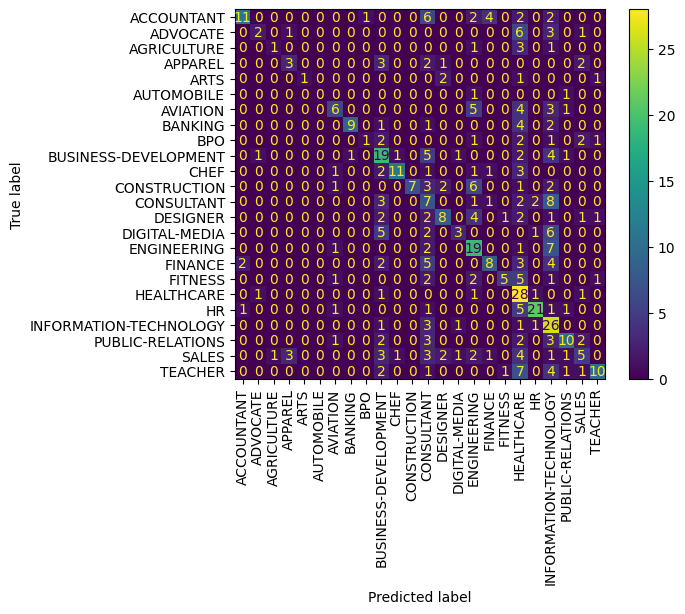

In [60]:
plt.figure(figsize=(15, 10))  # Imposta la dimensione della figura
ConfusionMatrixDisplay.from_predictions(y_test, prediction)
plt.xticks(rotation=90)
plt.show()

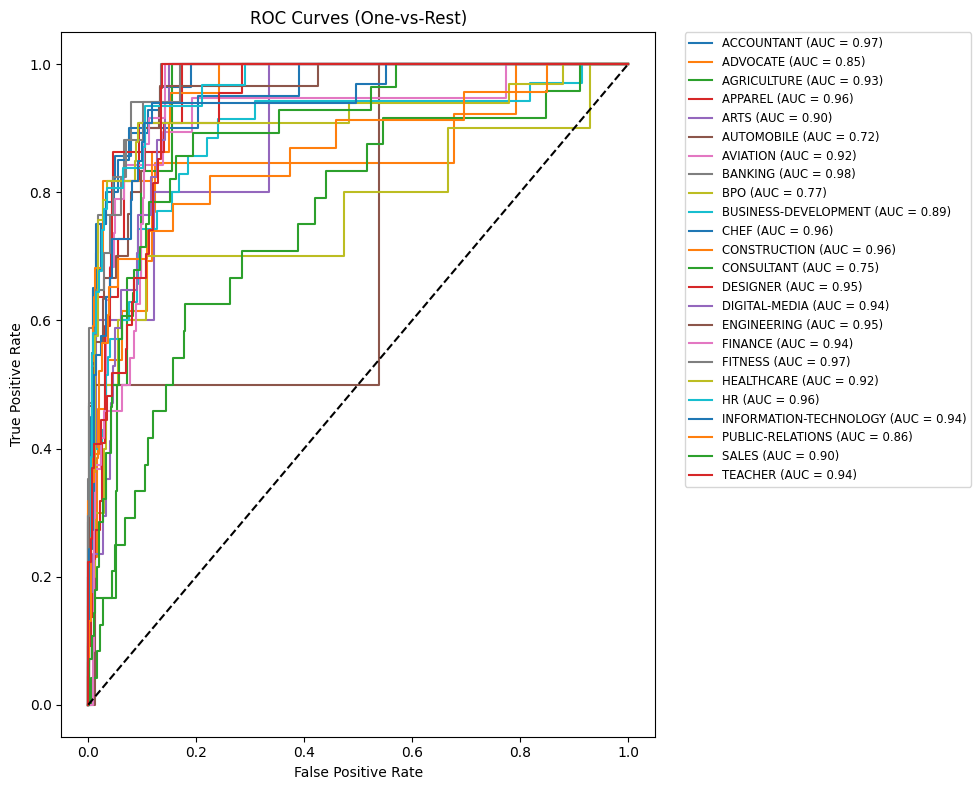

In [61]:
y_test_bin = label_binarize(y_test, classes=SVC_Model_best.classes_)
y_score = SVC_Model_best.predict_proba(X_test)

plt.figure(figsize=(10, 8))

for i in range(len(SVC_Model_best.classes_)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{SVC_Model_best.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")

# Sposta la legenda fuori dal grafico
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='small')
plt.tight_layout()
plt.show()

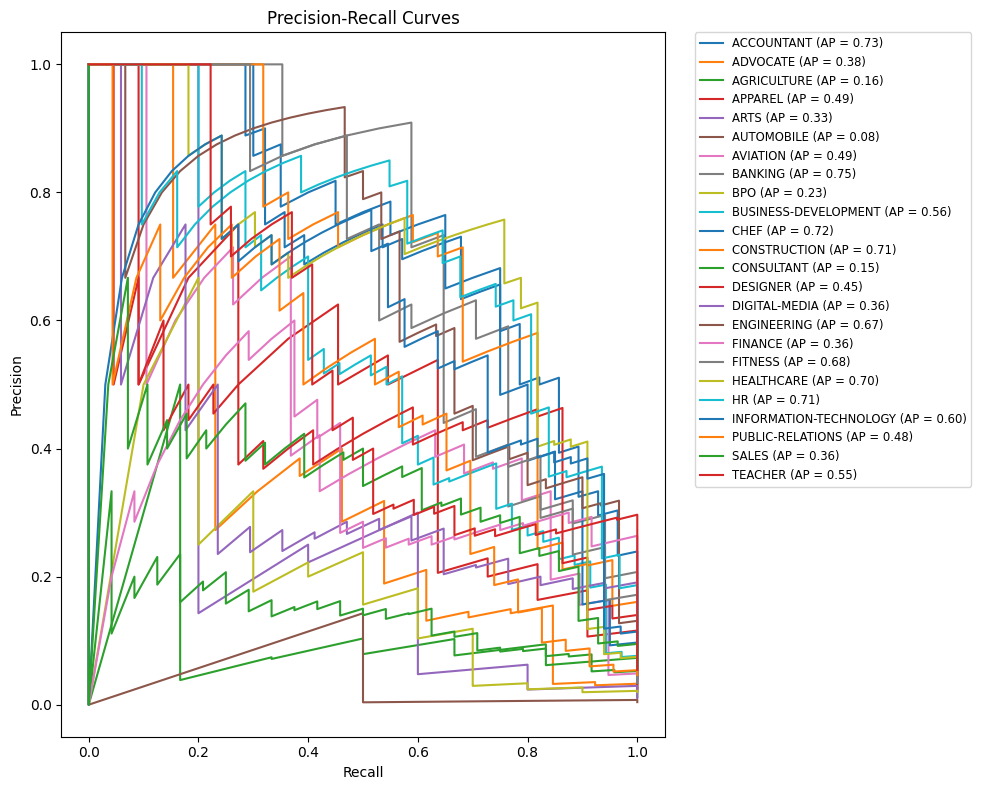

In [62]:
plt.figure(figsize=(10, 8))

for i in range(len(SVC_Model_best.classes_)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, label=f"{SVC_Model_best.classes_[i]} (AP = {avg_precision:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")

# Legenda esterna a destra
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='small')
plt.tight_layout()
plt.show()

In [63]:
import sys
sys.path.append('..')

from utils import save_experiment_D2V

save_experiment_D2V(d2v_model, grid_search, SVC_Model_best, X_train, y_train, X_test, y_test)

✅ Riga di log aggiunta in 'experiment_log.txt':
SVC(clf__C=10, clf__gamma=scale, clf__kernel=rbf) | D2V(vector_size=200, window=10, min_count=2, dm=True, epochs=20) | Accuracy train=1.000, test=0.445

